# 1 - Dataset

Given a set of text movie reviews that have been labeled negative or positive, we will classify the reviews text based on label.

For more information on this dataset visit http://ai.stanford.edu/~amaas/data/sentiment/

**We will imports and load the dataset into a pandas DataFrame**

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/Data_Science/Projects/Machine_Learning/Classification/Movie_Reviews_Sentiment_NLP/moviereviews.csv')

In [ ]:
df.head()

,label,review
0,neg,how do films like mouse hunt get into theatres...
1,neg,some talented actresses are blessed with a dem...
2,pos,this has been an extraordinary year for austra...
3,pos,according to hollywood movies made in last few...
4,neg,my first press screening of 1998 and already i...


In [ ]:
df.shape

(2000, 2)

---
---

# **2 - Exploratory Data Analysis and Feature Engineering**

## **A. Dealing with Missing Data**

**We check to see if there are any missing values in the dataframe.**

In [ ]:
df.isnull().sum()

label      0
review    35
dtype: int64

**We remove any reviews that are NaN**

In [ ]:
df = df.dropna(axis=0)

**We check to see if any reviews are blank strings and not just NaN. Note: This means a review text could just be: "" or "  " or some other larger blank string.**

In [ ]:
# Check if thera are any review that just a whitespace
df['review'].str.isspace().sum()

27

In [ ]:
df[df['review'].str.isspace()].head()

,label,review
57,neg,
71,pos,
147,pos,
151,pos,
283,pos,


**Lets drop this data that has blank review**

In [ ]:
blank_review = df[df['review'].str.isspace()]

In [ ]:
df = df.drop(blank_review.index, axis = 0)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1938 entries, 0 to 1999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   label   1938 non-null   object
 1   review  1938 non-null   object
dtypes: object(2)
memory usage: 45.4+ KB


**After we dealing with missing data, lets move to the next step.**

---

## **B. Label Count**

**Confirm the value counts per label:**

In [ ]:
df['label'].value_counts()

pos    969
neg    969
Name: label, dtype: int64

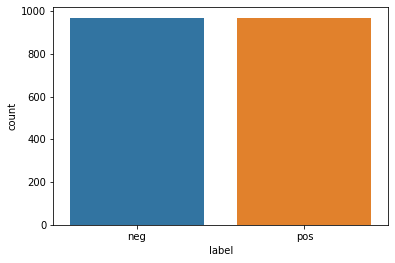

In [ ]:
sns.countplot(data=df, x='label');

**We can see that this dataset has balanced label of each class.**

---

## **C. Top Bag of Words**

**Bonus Task: Can you figure out how to use a CountVectorizer model to get the top 20 words (that are not english common words) per label type? Note, this is a bonus task as we did not show this in the lectures. But a quick cursory Google search should put you on the right path.  [Click me for a big hint](https://stackoverflow.com/questions/16288497/find-the-most-common-term-in-scikit-learn-classifier)**

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer

In [ ]:
# count the words
cv = CountVectorizer(stop_words='english')

### **a. Top 20 Words Used for Positive Reviews**

In [ ]:
pos_sparse_matrix = cv.fit_transform(df[df['label'] == 'pos']['review'])
pos_sparse_matrix

<969x29459 sparse matrix of type '<class 'numpy.int64'>'
	with 247042 stored elements in Compressed Sparse Row format>

In [ ]:
# Get words
pos_bag_of_words = cv.get_feature_names()

In [ ]:
# Sum all same word and change to 1D
pos_sum_of_words = pos_sparse_matrix.sum(axis=0).tolist()[0] 

In [ ]:
# zip to tuple, feature as key, sum of words as value
pos_words_freq = zip(pos_bag_of_words, pos_sum_of_words)

In [ ]:
# sort with highest value first (numerical order)
sorted_pos_words_freq = sorted(pos_words_freq, key=lambda x: (x[1],x[0]), reverse=True)
print(sorted_pos_words_freq[:20])

[('film', 5002), ('movie', 2389), ('like', 1721), ('just', 1273), ('story', 1199), ('good', 1193), ('time', 1175), ('character', 1037), ('life', 1032), ('characters', 957), ('way', 864), ('films', 851), ('does', 828), ('best', 788), ('people', 769), ('make', 764), ('little', 751), ('really', 731), ('man', 728), ('new', 702)]


In [ ]:
# Function to plot barplot of top 20 words used
def plot_top_20_words(words_freq):
  top_20_words = list()
  top_20_words_freq = list()

  for word, value in words_freq[:20]:
    top_20_words.append(word)
    top_20_words_freq.append(value)

  sns.barplot(x=top_20_words, y=top_20_words_freq)
  plt.xticks(rotation=90);

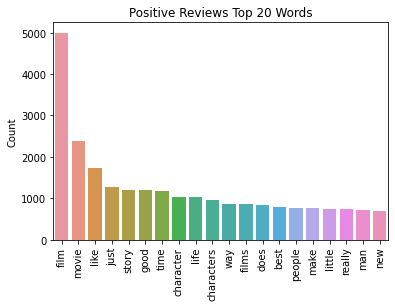

In [ ]:
plot_top_20_words(sorted_pos_words_freq)
plt.title('Positive Reviews Top 20 Words')
plt.ylabel('Count');

---

### **b. Top 20 Words Used for Negative Reviews**

In [ ]:
neg_sparse_matrix = cv.fit_transform(df[df['label'] == 'neg']['review'])
neg_sparse_matrix

<969x27473 sparse matrix of type '<class 'numpy.int64'>'
	with 223948 stored elements in Compressed Sparse Row format>

In [ ]:
# Get words
neg_bag_of_words = cv.get_feature_names()

In [ ]:
# Sum all same word and change to 1D
neg_sum_of_words = neg_sparse_matrix.sum(axis=0).tolist()[0] 

In [ ]:
# zip to tuple, feature as key, sum of words as value
neg_words_freq = zip(neg_bag_of_words, neg_sum_of_words)

In [ ]:
# sort with highest value first (numerical order)
sorted_neg_words_freq = sorted(neg_words_freq, key=lambda x: (x[1],x[0]), reverse=True)
print(sorted_neg_words_freq[:20])

[('film', 4063), ('movie', 3131), ('like', 1808), ('just', 1480), ('time', 1127), ('good', 1117), ('bad', 997), ('character', 926), ('story', 908), ('plot', 888), ('characters', 838), ('make', 813), ('really', 743), ('way', 734), ('little', 696), ('don', 683), ('does', 666), ('doesn', 648), ('action', 635), ('scene', 634)]


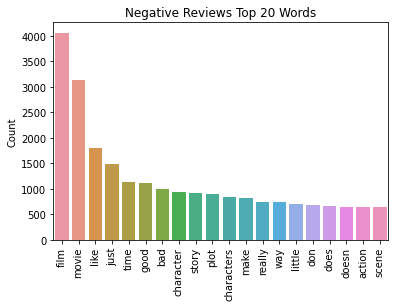

In [ ]:
plot_top_20_words(sorted_neg_words_freq)
plt.title('Negative Reviews Top 20 Words')
plt.ylabel('Count');

---
---

# **3 -  Machine Learning Model**

## **A. Setup**

#### **a. Stratified Train | Test Split**



**Split the data into features and a label (X and y) and then preform a train/test split using stratify to balance the ratio of split based on label.**

In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
X = df['review']
y = df['label']

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=101, stratify=np.array(y))

In [ ]:
X_train.shape

(1550,)

In [ ]:
X_test.shape

(388,)

---

### **b. TF-IDF Vectorization**

**Use Term Frequency-Inverse Document Frequency (TF-IDF) to count the words balance the words if the frequency of certain term occurs more often. So we will not lose information in the important words.**

**Also dont forget to fit the data only to training data to avoid data leakage to test data.**

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [ ]:
tfidf = TfidfVectorizer()

In [ ]:
# Fit to calculate statistical information on training set and transform it
X_train_tfidf = tfidf.fit_transform(X_train)

In [ ]:
X_test_tfidf = tfidf.transform(X_test)

---

## **B. Base Model Comparisons**

**After that, compare the training score in various machine learning model for use in Grid Search.**

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC, LinearSVC
from sklearn.naive_bayes import MultinomialNB

In [ ]:
model_list = [('log_reg', LogisticRegression()), 
              ('svc', SVC()), 
              ('lin_svc', LinearSVC()), 
              ('multi_nb', MultinomialNB())]

In [ ]:
from sklearn.model_selection import cross_val_score, StratifiedKFold

In [ ]:
skf = StratifiedKFold(n_splits=5)

for name, model in model_list:
  scores = cross_val_score(model, X_train_tfidf, y_train, cv=skf, scoring='accuracy')
  print(f'{name:<9}: {scores.mean():.5f}')

log_reg  : 0.80581
svc      : 0.81355
lin_svc  : 0.83871
multi_nb : 0.78839


**After using Cross Validation on various model, we can see that Linear SVC has highest score in accuracy. We will use this model in Grid Search to tuning the hyper-parameters.**

---

## **C. Linear SVC with Grid Search**

**In this section, we will create instance of Linear SVC and Grid Search. Using Grid Search we will tuning the hyper-parameters.**

**We tuning the C parameter that control the strength of inverse regularization. So more higher the C value, the bias will be lower but the variance will be higher (not allowing more misclassification).**

In [ ]:
lin_svc = LinearSVC(max_iter=5000)

In [ ]:
from sklearn.model_selection import GridSearchCV

In [ ]:
param_grid = {'C':[0.01, 0.1, 1, 5, 10, 15, 20, 25, 50, 75, 100]}

In [ ]:
grid_lin_svc = GridSearchCV(lin_svc, 
                            param_grid, 
                            cv=skf, 
                            scoring='accuracy')

---

### **a. Fit/Train the Model**

**Fit the model to the training data**

In [ ]:
grid_lin_svc.fit(X_train_tfidf, y_train)

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
             error_score=nan,
             estimator=LinearSVC(C=1.0, class_weight=None, dual=True,
                                 fit_intercept=True, intercept_scaling=1,
                                 loss='squared_hinge', max_iter=5000,
                                 multi_class='ovr', penalty='l2',
                                 random_state=None, tol=0.0001, verbose=0),
             iid='deprecated', n_jobs=None,
             param_grid={'C': [0.01, 0.1, 1, 5, 10, 15, 20, 25, 50, 75, 100]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='accuracy', verbose=0)

---

### **b. Model Best Parameter and Score**

In [ ]:
grid_lin_svc.best_estimator_

LinearSVC(C=50, class_weight=None, dual=True, fit_intercept=True,
          intercept_scaling=1, loss='squared_hinge', max_iter=5000,
          multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
          verbose=0)

**Get the tuned parameter and it best score (accuracy in this term)**

In [ ]:
grid_lin_svc.best_params_

{'C': 50}

**Get training accuracy of the model**

In [ ]:
grid_lin_svc.best_score_

0.8400000000000002

---

### **c. Performance Evaluation**

**After we train the model, we test it's performance with test data (hold-out data in this case). So make sure the model never see this data before to avoid overfitting.**

In [ ]:
from sklearn.metrics import plot_confusion_matrix, classification_report, accuracy_score

**Predict the label with test data.**

In [ ]:
y_pred = grid_lin_svc.predict(X_test_tfidf)

In [ ]:
accuracy_score(y_test, y_pred)

0.8711340206185567

**The training accuracy and test accuracy is good and not much different each other, so this model is not overfitting.**

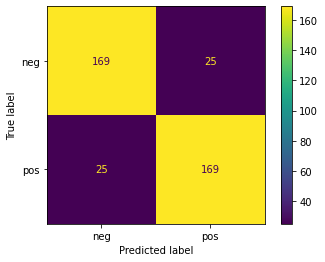

In [ ]:
plot_confusion_matrix(grid_lin_svc, X_test_tfidf, y_test, values_format='d');

In [ ]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         neg       0.87      0.87      0.87       194
         pos       0.87      0.87      0.87       194

    accuracy                           0.87       388
   macro avg       0.87      0.87      0.87       388
weighted avg       0.87      0.87      0.87       388



**We can see, that we have good f1-score (balance precision and recall) and accuracy in both label. That means this model is good to be deploy.**

**After this, we can finalize our model.**

---
---

# **4 - Finalizing the Model**

## **A. Create Pipeline**

**We will use Pipeline to assign TF-IDF and Machine Learning model in one go.**

**For model, we use the best parameter we get from grid search.**

In [ ]:
from sklearn.pipeline import Pipeline

In [ ]:
lin_svc_pipe = Pipeline([('tfidf', TfidfVectorizer()), 
                         ('lin_svc', LinearSVC(C=50, max_iter=5000))])

---

## **B. Re-Fit/Train the Model**

**Then we train the model with all the data, so we will have our generalized model**

In [ ]:
lin_svc_pipe.fit(X, y)

Pipeline(memory=None,
         steps=[('tfidf',
                 TfidfVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.float64'>,
                                 encoding='utf-8', input='content',
                                 lowercase=True, max_df=1.0, max_features=None,
                                 min_df=1, ngram_range=(1, 1), norm='l2',
                                 preprocessor=None, smooth_idf=True,
                                 stop_words=None, strip_accents=None,
                                 sublinear_tf=False,
                                 token_pattern='(?u)\\b\\w\\w+\\b',
                                 tokenizer=None, use_idf=True,
                                 vocabulary=None)),
                ('lin_svc',
                 LinearSVC(C=50, class_weight=None, dual=True,
                           fit_intercept=True, intercept_scaling=1,
            

---

## **C. Saving the Model**

**We can save our model to use it in another platform**

In [ ]:
from joblib import dump, load

In [ ]:
dump(lin_svc_pipe, '/content/drive/MyDrive/Data_Science/Projects/Machine_Learning/Classification/Movie_Reviews_Sentiment_NLP/movie_reviews_sentiment_NLP.joblib') 

['/content/drive/MyDrive/Data_Science/Projects/Machine_Learning/Classification/Movie_Reviews_Sentiment_NLP/movie_reviews_sentiment_NLP.joblib']

---

## **D. Load and Test the Model**

**Let's load the model and test it to new data**

In [ ]:
loaded_model = load('/content/drive/MyDrive/Data_Science/Projects/Machine_Learning/Classification/Movie_Reviews_Sentiment_NLP/movie_reviews_sentiment_NLP.joblib')

In [ ]:
new_review = ['bad movie and acting']
loaded_model.predict(new_review)

array(['neg'], dtype=object)

In [ ]:
new_review = ['ok movie but still good in acting']
loaded_model.predict(new_review)

array(['pos'], dtype=object)

In [ ]:
new_review = ['overall this is a good movie']
loaded_model.predict(new_review)

array(['pos'], dtype=object)